# Court Plotting

Creating a template to plot an NBA court, can be used as a base for shot charts, etc. 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

## Final Function
Set the NBA player name and season below, and a shot chart will be generated.
Current the default season is last season using the NBA_api `season` class - but you can change to a string in the format 'YYYY-YY'.

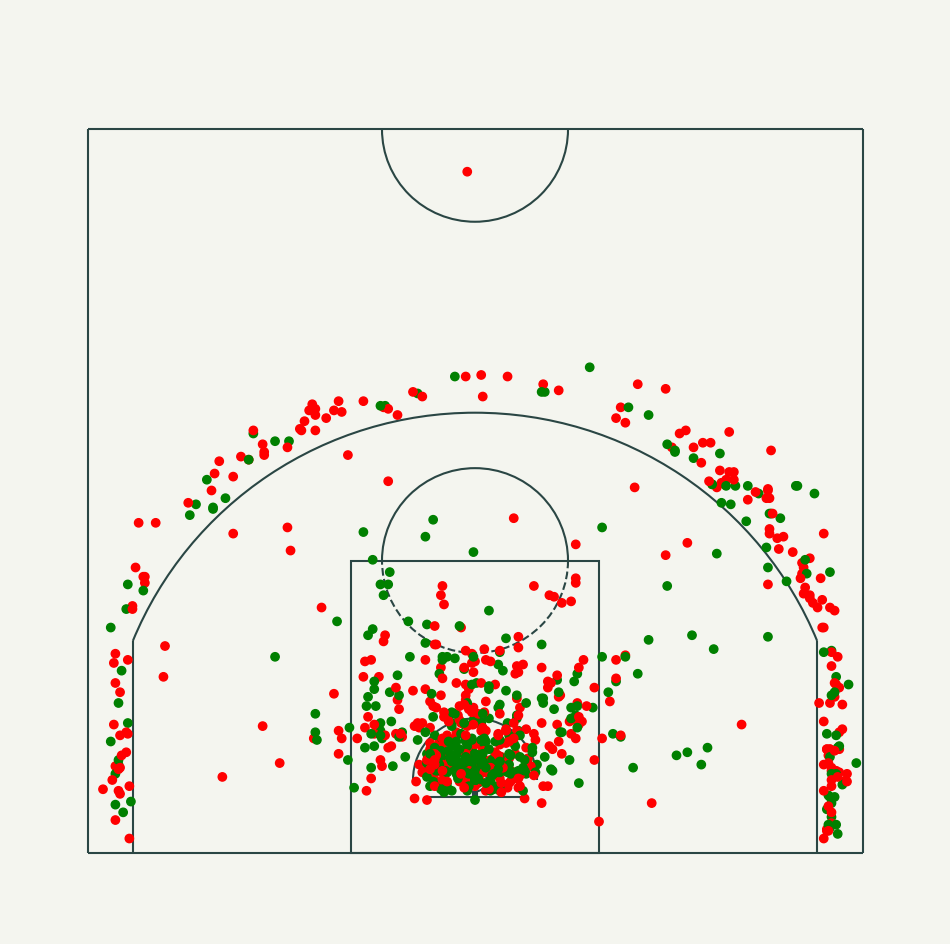

In [124]:
player_name = 'Josh Giddey'
season = Season.previous_season

plot_shot_chart(player_name, season)

## Imports

In [116]:
%matplotlib inline
import time
import urllib
import pandas as pd

from functools import wraps

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
from matplotlib.colors import ListedColormap

from nba_api.stats.static import players
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.library.parameters import Season

player_dict = players.get_active_players()

In [103]:
def plot_shot_chart(player_name, season):

  # Retrieve player name from player dictionary
  player_id = [player['id'] for player in player_dict if player['full_name'].lower() == player_name.lower()][0]

  shotsDF = get_shooting_locations(player_id=player_id, season=season)
  plot_shots(shotsDF)


## Plotting

In [89]:
def draw_court(ax=None, color='black', lw=1.5, facecolor='#F4F5EF', halfcourt=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court
    
    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard and connect to hoop
    backboard = Rectangle((-30, -11), 60, 0, linewidth=lw, color=color)
    connection = Rectangle((-1, -11), 2, 3, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    
    # Restricted Area, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220.5, -47.5), 0, 137.5, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220.5, -47.5), 0, 137.5, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    three_arc = Arc((0, 0), 477, 477, theta1=22.25, theta2=157.75, linewidth=lw,
                    color=color)
    
    baseline = Rectangle((-250, -47.5), 500, 0, linewidth=lw, color=color)

    # Halfcourt
    center_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    l_side = Rectangle((-250, -47.5), 0, 470, linewidth=lw, color=color)
    r_side = Rectangle((250, -47.5), 0, 470, linewidth=lw, color=color)
    halfway = Rectangle((-250, 470), 500, 0, linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, connection, outer_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, baseline]
    
    if halfcourt:
        court_elements.extend([center_arc, l_side, r_side, halfway])

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [102]:
def plot_shots(shotsDF):
  fig, ax = plt.subplots(figsize=(12, 12))

  # Call draw_court and pass the Axes object (ax)
  draw_court(halfcourt=True, ax=ax, color='#2A4644')

  cmap = ListedColormap(['red', 'green'])
  ax.scatter(shotsDF.LOC_X, shotsDF.LOC_Y, c=shotsDF.SHOT_MADE_FLAG, cmap=cmap)

  # Set limits and hide the axes
  ax.set_xlim(300, -300)
  ax.set_ylim(-100, 500)
  fig.patch.set_facecolor('#F4F5EF')
  ax.axis('off')

  # Display the plot
  plt.show()


## Data

In [106]:
# Retry Wrapper 
def retry(max_attempts=3, delay=30):
  def decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
      attempts = 0
      while attempts < max_attempts:
        try:
          return func(*args, **kwargs)
        except Exception as e:
          print(f"Attempt {attempts + 1} failed: {e}")
          attempts += 1
          if attempts < max_attempts:
              print(f"Retrying in {delay} seconds...")
              time.sleep(delay)
      raise Exception(f"Function {func.__name__} failed after {max_attempts} attempts")
    return wrapper
  return decorator

  
@retry(max_attempts=3, delay=30)
def get_shooting_locations(team_id=0, player_id=203999, season=season): #Defaults to Nikola Jokic
  return shotchartdetail.ShotChartDetail(
                                         team_id=team_id,
                                         player_id=player_id,
                                         season_nullable=season,
                                         context_measure_simple='FGA'
                                         ).shot_chart_detail.get_data_frame()